# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете. 
        Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    </li>
</ol>

## Будем предсказывать дневные цены акций Газпрома (тикер 'GAZP' на MOEX) на основе 10-летнего временного ряда##

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader

from datetime import datetime

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/content/GAZP_10_yrs.csv', sep= ',', engine='python')
df.tail()

,DATE,OPEN,HIGH,LOW,CLOSE,VOL
2520,20200710,198.25,201.70,197.22,200.94,39028520
2521,20200713,201.60,202.33,195.50,195.70,62999870
2522,20200714,195.09,196.65,192.48,193.60,83060710
2523,20200715,180.60,184.27,179.80,182.26,73463320
2524,20200716,181.20,183.79,181.07,183.76,25395950


Посмотрим на всю совокупность графиков OPEN, HIGH, LOW, CLOSE

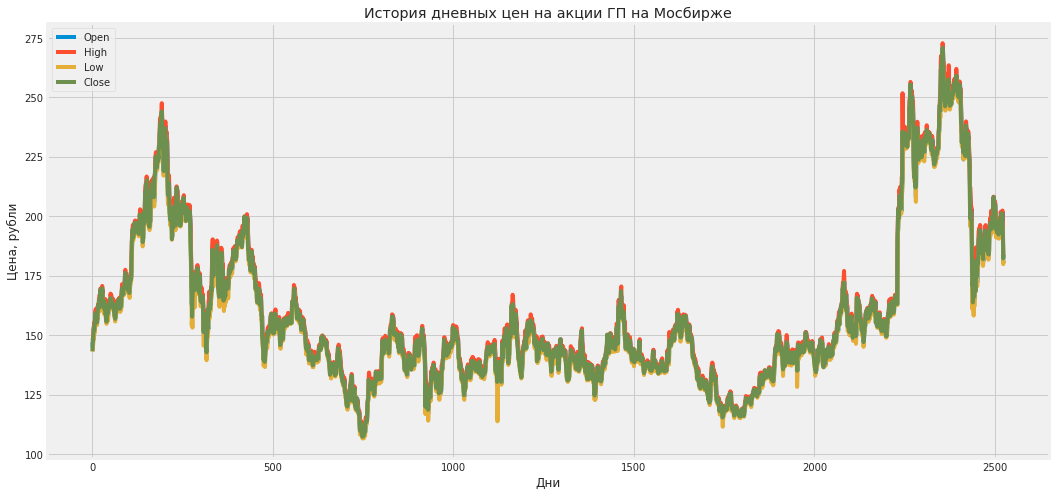

In [3]:
plt.figure(figsize=(16,8))
plt.plot(df['OPEN'])
plt.plot(df['HIGH'])
plt.plot(df['LOW'])
plt.plot(df['CLOSE'])
plt.title('История дневных цен на акции ГП на Мосбирже')
plt.ylabel('Цена, рубли')
plt.xlabel('Дни')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

Видно, что цены идут кучно, за исключением пары эпизодов с провалами по LOW

Посмотрим на объемы торговли

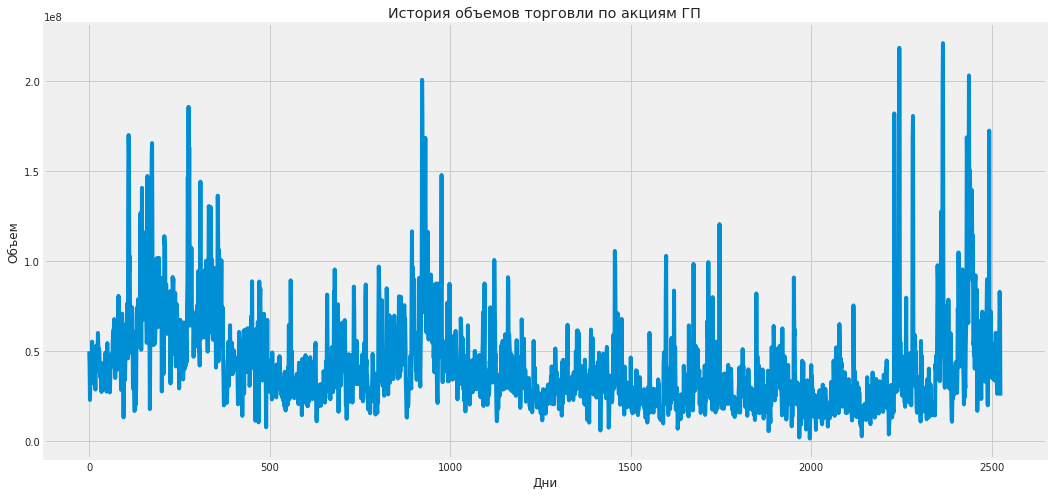

In [4]:
plt.figure(figsize=(16,8))
plt.plot(df['VOL'])
plt.title('История объемов торговли по акциям ГП')
plt.ylabel('Объем')
plt.xlabel('Дни')
plt.show()

Картинка неоднородная. Много всплесков. Нужно смотреть что за события были, но в среднем по больнице можно предположить, что они сильно коррелируют с политическими событиями.

Посмотрим есть ли Null/Nan значения

In [5]:
df.isna().sum()

DATE     0
OPEN     0
HIGH     0
LOW      0
CLOSE    0
VOL      0
dtype: int64

Отлично!

In [6]:
data = df.iloc[:,1:].values
data = np.array(data)
data.shape[1]

5

In [7]:
xLen = 30

channelIndexes = [0,1,2,3,4]
xTrain = np.array([data[i:i+xLen, channelIndexes] for i in range(data.shape[0]-xLen-1)])
print(xTrain.shape)

yTrain = np.array([data[i+xLen][0] for i in range(data.shape[0]-xLen-1)])

print(yTrain.shape)
yTrain = yTrain.reshape(yTrain.shape[0],1)
print(yTrain.shape)

(2494, 30, 5)
(2494,)
(2494, 1)


In [8]:
yTrain.shape

(2494, 1)

In [9]:
xTrainF = np.array([d.flatten() for d in xTrain])
print(xTrainF.shape)

(2494, 150)


In [10]:
xFScaler = StandardScaler()
print(xFScaler.fit(xTrainF))
xTrainFScaled = xFScaler.transform(xTrainF)

yScaler = MinMaxScaler((0,1))
print(yScaler.fit(yTrain))
yTrainScaled = yScaler.transform(yTrain)


xTrainLen = xTrainF.shape[0]
valLen = 400
bias = xLen + 10


xValFScaled = xTrainFScaled[xTrainLen-valLen:]
yValScaled = yTrainScaled[xTrainLen-valLen:]


xTrainFScaled = xTrainFScaled[:xTrainLen-valLen-bias]
yTrainScaled = yTrainScaled[:xTrainLen-valLen-bias]

yVal = yTrain[xTrainLen-valLen:]

StandardScaler(copy=True, with_mean=True, with_std=True)
MinMaxScaler(copy=True, feature_range=(0, 1))


In [11]:
print(xTrainFScaled.shape)
print(xValFScaled.shape)

(2054, 150)
(400, 150)


In [12]:
xTrainScaled = []
xValScaled = []

channels = xTrain.shape[2]
for i in range(xTrainFScaled.shape[0]):
  currXTRain = []
  for j in range(channels):
    currXTRain.append(xTrainFScaled[i][range(j,xTrainFScaled.shape[1],channels)])
  
  currXTRain = np.array(currXTRain).T
  xTrainScaled.append(currXTRain)


for i in range(xValFScaled.shape[0]):
  currXVal = []
  for j in range(channels):
    currXVal.append(xValFScaled[i][range(j,xTrainFScaled.shape[1],channels)])
  
  currXVal = np.array(currXVal).T
  xValScaled.append(currXVal)
  
  
xTrainScaled = np.array(xTrainScaled)
xValScaled = np.array(xValScaled)

print(xTrainScaled.shape)
print(xValScaled.shape)

(2054, 30, 5)
(400, 30, 5)


In [13]:
print(xTrainFScaled.shape)
print(yTrainScaled.shape)
print(xValFScaled.shape)
print(yValScaled.shape)

(2054, 150)
(2054, 1)
(400, 150)
(400, 1)


In [14]:
yTrain[:5]

array([[161.85],
       [163.41],
       [161.19],
       [163.37],
       [163.9 ]])

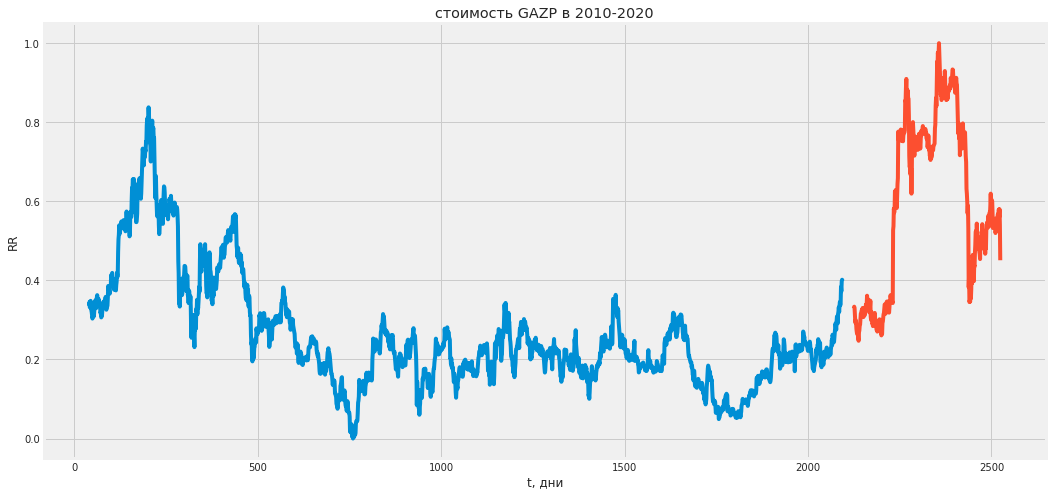

In [15]:
plt.figure(figsize=(16,8))
plt.plot(df.index[11+xLen:yTrainScaled.shape[0]+xLen+11],yTrainScaled[:,0])
plt.plot(df.index[yTrainScaled.shape[0]+xLen+41:],yValScaled[:,0])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('RR')
plt.title('стоимость GAZP в 2010-2020')
plt.show()

In [16]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

Train on 2054 samples, validate on 400 samples
Epoch 1/20
2054/2054 [==============================] - 3s 2ms/step - loss: 0.0085 - mae: 0.0603 - val_loss: 0.0209 - val_mae: 0.1096
Epoch 2/20
2054/2054 [==============================] - 3s 1ms/step - loss: 0.0023 - mae: 0.0362 - val_loss: 0.0234 - val_mae: 0.1151
Epoch 3/20
2054/2054 [==============================] - 2s 1ms/step - loss: 0.0018 - mae: 0.0316 - val_loss: 0.0185 - val_mae: 0.1022
Epoch 4/20
2054/2054 [==============================] - 2s 1ms/step - loss: 0.0016 - mae: 0.0289 - val_loss: 0.0096 - val_mae: 0.0736
Epoch 5/20
2054/2054 [==============================] - 2s 1ms/step - loss: 0.0012 - mae: 0.0254 - val_loss: 0.0171 - val_mae: 0.0967
Epoch 6/20
2054/2054 [==============================] - 2s 1ms/step - loss: 0.0011 - mae: 0.0250 - val_loss: 0.0118 - val_mae: 0.0774


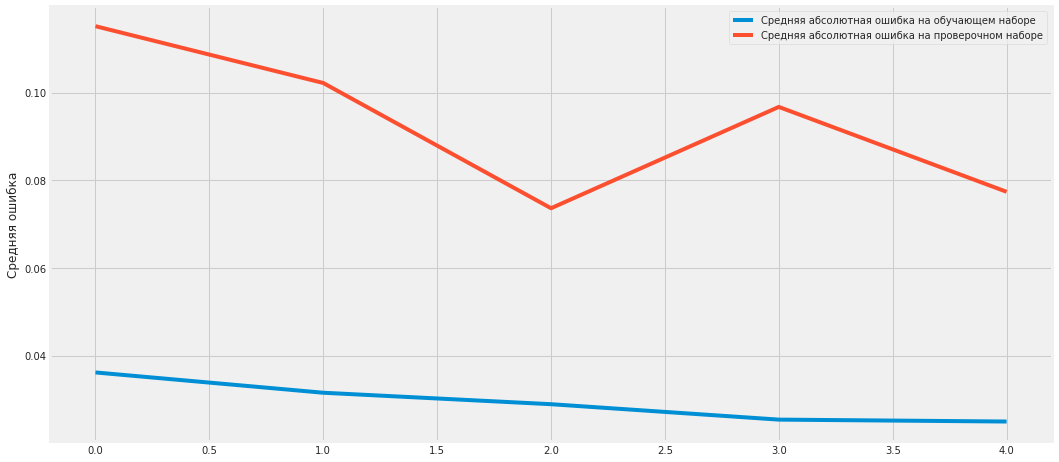

In [17]:
callback = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(10, input_shape = (xTrain.shape[1], xTrain.shape[2]), return_sequences="True"))
model.add(LSTM(20, return_sequences="True"))
model.add(Conv1D(10, 5, activation="linear"))
model.add(Conv1D(10, 5, activation="linear"))
model.add(Flatten())
model.add(Dense(5, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(xTrainScaled, 
                    yTrainScaled, 
                    epochs=20, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xValScaled, yValScaled),
                    callbacks=[callback])

plt.figure(figsize=(16,8))
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [18]:
pred = yScaler.inverse_transform(model.predict(xTrainScaled)).flatten()
predVal = yScaler.inverse_transform(model.predict(xValScaled)).flatten()

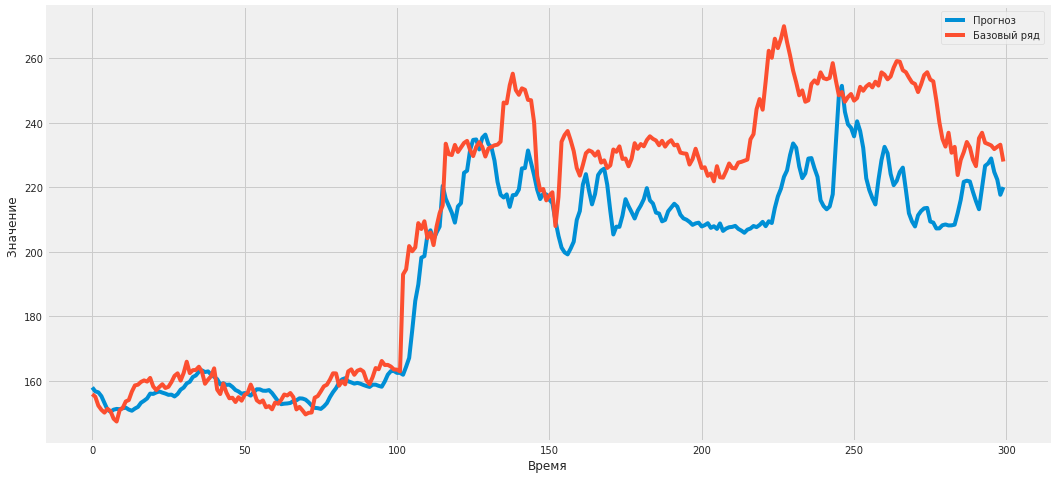

In [19]:
start = 5
step = 300
plt.figure(figsize=(16,8))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Модель улавливает тренд. Посмотрим как можно улучшить.

Train on 2054 samples, validate on 400 samples
Epoch 1/20
2054/2054 [==============================] - 3s 2ms/step - loss: 0.0105 - mae: 0.0660 - val_loss: 0.0093 - val_mae: 0.0714
Epoch 2/20
2054/2054 [==============================] - 2s 1ms/step - loss: 0.0016 - mae: 0.0298 - val_loss: 0.0155 - val_mae: 0.0950
Epoch 3/20
2054/2054 [==============================] - 2s 1ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0064 - val_mae: 0.0599
Epoch 4/20
2054/2054 [==============================] - 2s 1ms/step - loss: 9.7783e-04 - mae: 0.0230 - val_loss: 0.0109 - val_mae: 0.0790
Epoch 5/20
2054/2054 [==============================] - 2s 1ms/step - loss: 9.1040e-04 - mae: 0.0224 - val_loss: 0.0072 - val_mae: 0.0633


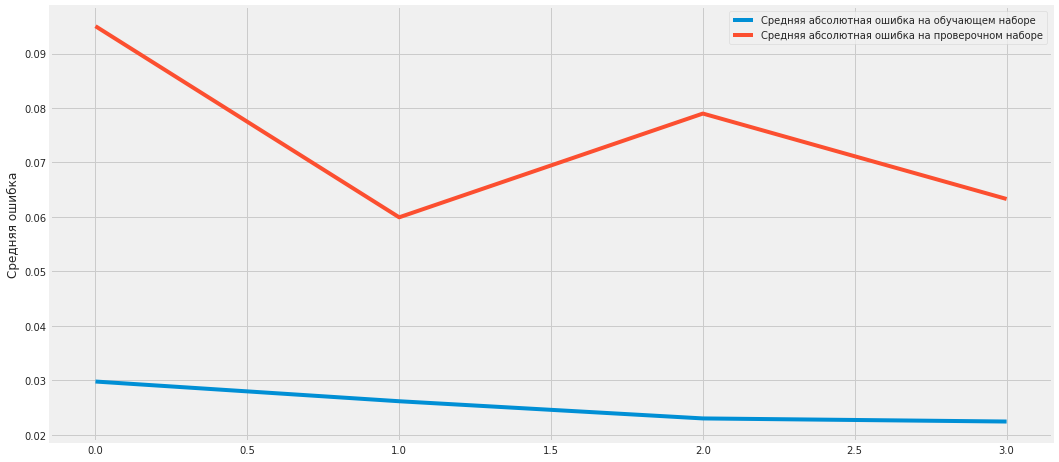

In [32]:
callback = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

#model.add(LSTM(10, input_shape = (xTrain.shape[1], xTrain.shape[2]), return_sequences="True"))
#model.add(LSTM(20, return_sequences="False"))
#model.add(Conv1D(10, 5, activation="linear"))
#model.add(Conv1D(10, 5, activation="linear"))
#model.add(Flatten())
#model.add(Dense(5, activation="linear"))
#model.add(Dense(1, activation="linear"))

model.add(LSTM(50, input_shape = (xTrain.shape[1], xTrain.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences= True))
#model.add(Conv1D(10, 5, activation='linear'))
model.add(Conv1D(10, 5, activation='linear'))
model.add(Flatten())
model.add(Dense(25, activation='linear'))
model.add(Dense(1, activation='linear'))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(xTrainScaled, 
                    yTrainScaled, 
                    epochs=20, 
                    batch_size=30, 
                    verbose=1,
                    validation_data=(xValScaled, yValScaled),
                    callbacks=[callback])

plt.figure(figsize=(16,8))
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

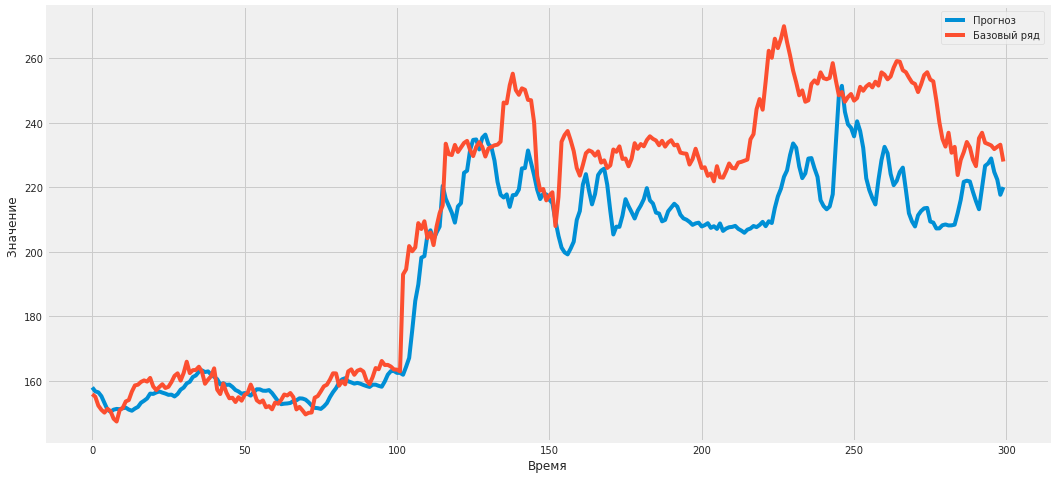

In [29]:
start = 5
step = 300
plt.figure(figsize=(16,8))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Итак, сценарий эксперимента был следующий:<br>
1) менять количество ядер<br>
2) менять количество слоев<br>
3) менять batchsize<br>
4) Указывать / не указывать способ активации в dense-слоях<br>

__В итоге:__<br>
Улучшения удалось добиться следующим образом:<br>
1) увеличение количества ядер в LSTM слоях до 50 в каждом из 2-х<br>
2) уменьшение количества сверточных слоев до одного<br>
3) увеличение batch-size с 20 до 30


